# Gammel kode

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold, GridSearchCV

#load data from txt file with pandas
data = pd.read_csv('case1Data.txt', sep=", ", engine='python')
y = data['y']

X = pd.read_csv('case1Data_one_hot.csv').to_numpy()
X_new = pd.read_csv('case1Data_Xnew_one_hot.csv').to_numpy()
y_vec = y.values

In [ ]:
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, X_new = None):
        self.X_new = X_new
        self.scaler = StandardScaler()

    def fit(self, X, y = None):
        self.scaler.fit(np.concatenate((X[:,:95], self.X_new[:,:95]), axis = 0))
        #print('scaler fit')
        return self

    def transform(self, X, y = None):
        X_con = self.scaler.transform(X[:,:95])
        X = np.concatenate((X_con, X[:,95:]), axis = 1)
        return X
    
class CustomKNNImputer(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=1, weights='distance', X_new = None):
        #print('CustomKNNImputer init')
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.X_new = X_new

    def fit(self, X, y = None):
        self.scaler = CustomScaler(X_new = self.X_new).fit(X)
        X_new_norm = self.scaler.transform(self.X_new)
        data = np.concatenate((X, X_new_norm), axis = 0)
        self.imputer = KNNImputer(n_neighbors = self.n_neighbors, weights = self.weights)
        self.imputer.fit(data)
        return self

    def transform(self, X, y = None):
        X = self.imputer.transform(X)
        N = X.shape[0]
        for i in range(N):
            for j in range(4):
                idx = np.argmax(X[i, 95+(j*5) : 95+(j+1)*5 ])
                X[i, 95+(j*5) : 95+(j+1)*5 ] = 0,0,0,0,0
                X[i, 95+(j*5) + idx] = 1
        return X
    
class Debugger(BaseEstimator, TransformerMixin):

    def transform(self, data):
        print("Shape of data at this point", data.shape)
        print(pd.DataFrame(data).head())
        return data

    def fit(self, data, y=None, **fit_params):
        # No need to fit anything, because this is not an actual  transformation. 
        return self

In [ ]:
from sklearn.linear_model import Lasso

# Define the pipeline
scaler = CustomScaler(X_new=X_new)
imputer = CustomKNNImputer(X_new = X_new)
model = Lasso(max_iter=10000)
pipe = Pipeline(steps=[('scale', scaler), ('impute', imputer), ('model', model)])

param_grid = {'impute__weights': ['uniform', 'distance'], 
              'impute__n_neighbors': range(3, 10), 
              'model__alpha': np.linspace(0.1, 3, 10)
              }

# Define the cross-validation
K_outer = 5
K_inner = 3
outer_cv = KFold(n_splits=K_outer, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=K_inner, shuffle=True, random_state=42)

# Perform the grid search
RMSE = np.zeros(K_outer)
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X)):
    print(f"Running outer fold {i+1}/{K_outer}")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_vec[train_idx], y_vec[test_idx]
    search = GridSearchCV(pipe, param_grid, cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1, refit = True)
    search.fit(X_train, y_train)
    best_params = search.best_params_

    pipe.set_params(**best_params)
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    #best_model = result.best_estimator_
    #preds = best_model.predict(X_test)

    RMSE[i] = np.sqrt(np.mean((preds - y_test)**2))
    print("Best parameter (CV score=%0.3f):" % search.best_score_, search.best_params_, 'RMSE:', f"{RMSE[i]:.3f}")


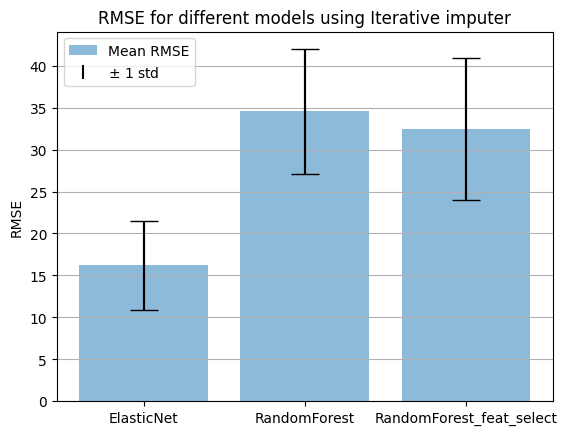

In [7]:
import pickle
RMSE = pickle.load(open('RMSE_dict_iterativeImputer_test_featselect.pkl', 'rb'))

#Remove lars key from rmse dict
RMSE.pop('Lars')
#plot the RMSE with lars
fig, ax = plt.subplots()
models = list(RMSE.keys())
mean = [round(RMSE[model].mean(), 4) for model in models]
std = [round(RMSE[model].std(), 4) for model in models]
ax.bar(models, mean, yerr=std, align='center', alpha=0.5, ecolor='black', capsize=10, label='Mean RMSE')
ax.errorbar(models, mean, yerr=std, fmt='o', color='black', label='$\pm$ 1 std', markersize=0.1)
ax.legend()
ax.set_ylabel('RMSE')
ax.set_title('RMSE for different models using Iterative imputer')
ax.yaxis.grid(True)
    #save the figure
#plt.savefig('RMSE_models_iterativeImputer_test_featselect.png')